<a href="https://colab.research.google.com/github/AnnyshkaF/High-Performance-Lab/blob/main/task_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CuPy-based Bifurcation map

By using <u><i><strong>CuPy</strong></i></u>, reimplement bifurcation map

In [ ]:
import matplotlib.pyplot as plt
import cupy as cp
import numpy as np

In [ ]:
MAX = 3_000_000
N = 100
M = 200

In [ ]:
def plot(x, y):
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, 'b.', markersize=0.1)
    
    plt.title('Bifurcation map')
    plt.xlabel('r')
    plt.ylabel('x')
    
def log_map(r, x):
    return r * x * (1 - x)

# Numpy implementation

In [ ]:
def bifurcation_map(n, m, r):
    y = np.zeros((m, len(r)))
    x = np.random.uniform(size=len(r))
    
    for _ in range(n):
        x = log_map(r, x)
        
    for i in range(m):
        x = log_map(r, x)
        y[i] = x
        
    return y.T

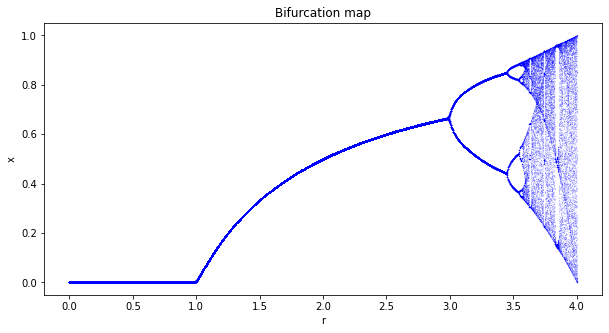

In [ ]:
r_linspace = np.linspace(0, 4, num=1000)
history = bifurcation_map(N, M, r_linspace)
plot(r_linspace, history)

**Measure numpy time**

In [ ]:
steps = np.linspace(0, 4, num=MAX)
time_np = %timeit -o -r 3 bifurcation_map(N, M, steps)

5.17 s ± 1.69 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


# Cupy implementation

In [ ]:
def bifurcation_map_cupy(n, m, r, function):
    y = cp.zeros((m, len(r)))
    x = cp.random.uniform(size=len(r))
    
    for _ in range(n):
        x = function(r, x)
    
    for i in range(m):
        x = function(r, x)
        y[i] = x
        
    return y.T

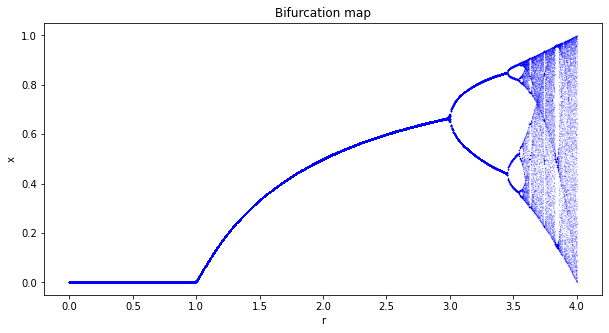

In [ ]:
steps = cp.linspace(0, 4, num=1000)
y = bifurcation_map_cupy(N, M, steps, log_map)
plot(steps.get(), y.get())

**Measure cupy time**

In [ ]:
steps = cp.linspace(0, 4, num=MAX)
time_cp = %timeit -o -r 3 bifurcation_map_cupy(N, M, steps, log_map)

135 ms ± 12.6 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


## Profile

In [ ]:
import cProfile
cProfile.run('bifurcation_map_cupy(N, M, steps, log_map)')

         1621 function calls in 0.131 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      300    0.077    0.000    0.077    0.000 1268922251.py:9(log_map)
        1    0.053    0.053    0.131    0.131 2788905165.py:1(bifurcation_map_cupy)
      300    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(min_scalar_type)
        1    0.000    0.000    0.131    0.131 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 _distributions.py:822(uniform)
        1    0.000    0.000    0.000    0.000 _generator.py:1198(get_random_state)
        1    0.000    0.000    0.000    0.000 _generator.py:1234(_check_and_get_dtype)
        1    0.000    0.000    0.000    0.000 _generator.py:598(_random_sample_raw)
        1    0.000    0.000    0.000    0.000 _generator.py:608(random_sample)
        1    0.000    0.000    0.000    0.000 _generator.py:910(uniform)
        1    0.000    0.000    0.000    0.000 basi

## Graph

In [ ]:
STEP = np.arange(1_000, 3_001_000, 500_000)
time_np = np.zeros(STEP.size)
time_cp = np.zeros(STEP.size)
time_cp_kernel = np.zeros(STEP.size)
time_mpi = np.zeros(STEP.size)
for i, size in enumerate(STEP):
    print(f'\r{i+1}/{STEP.size}', end='')
    
    steps = np.linspace(0, 4, num=size)
    time = %timeit -o -q -r 2 -n 1 bifurcation_map(N, M, steps)
    time_np[i] = time.best
    
    time = %timeit -o -q -r 2 -n 1 !mpirun -n 20 python bifurcation_mpi.py {size}
    time_mpi[i] = time.best
    
    steps = cp.array(steps)
    time = %timeit -o -q -r 2 -n 1 bifurcation_map_cupy(N, M, steps, log_map)
    time_cp[i] = time.best

6/6

Text(0, 0.5, 'Computational time')

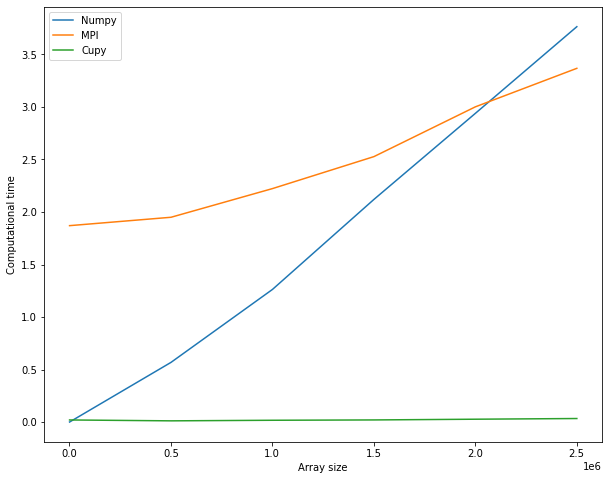

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(STEP, time_np, label='Numpy')
plt.plot(STEP, time_mpi, label='MPI')
plt.plot(STEP, time_cp, label='Cupy')
plt.legend()
plt.xlabel('Array size')
plt.ylabel('Computational time')

Create file with mpi implementation before running the above code

In [ ]:
%%writefile bifurcation_mpi.py

import sys
import time
import numpy as np
import matplotlib.pyplot as plt

from mpi4py import MPI


def logistic_map(r, x):
    return r * x * (1 - x)


comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

linspace_size = int(sys.argv[1])
n = 100
m = 200

r = np.linspace(0, 4, linspace_size, dtype=np.float32)
calc_size = linspace_size // size

if rank == 0:
    start = time.time()
    history = np.zeros(linspace_size * m, dtype=np.float32)
else:
    history = None

rank_r = r[calc_size * rank:calc_size * rank + calc_size]
if rank == (size - 1):
    rank_r = r[calc_size * rank:]

x = np.random.uniform(size=len(rank_r))
ans = np.empty((m , len(rank_r)), dtype=np.float32)
for _ in range(n):
    x = logistic_map(rank_r, x)
for i in range(m):
    x = logistic_map(rank_r, x)
    ans[i] = x
ans = ans.T.reshape(-1)

sendcounts = np.array(comm.gather(len(ans), 0))

comm.Gatherv(sendbuf=ans, recvbuf=(history, sendcounts), root=0)

if rank == 0:
    history = history.reshape((linspace_size, m))
#     print('Time: {:.3f}s'.format(time.time() - start))
#     plt.figure(figsize=(15, 5))
#     plt.plot(r, history, 'k.', markersize=0.15)

#     plt.title('Bifurcation map, n={}, m={}'.format(n, m))
#     plt.xlabel('r')
#     plt.ylabel('x')
#     plt.savefig('out.png')


Overwriting bifurcation_mpi.py
